In [164]:
import numpy as np
import pandas as pd
import torch

from torch.nn import functional as F
from annoy import AnnoyIndex
from requests_html import HTMLSession

from news_vec.encoder import read_preds
from news_vec.utils import read_json_gz_lines

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

In [2]:
UMAP_POINTS = pd.read_json('data/umap-points.json', lines=True)

In [16]:
def plot_umap(points, palette, title=None, dst=None):
    
    plt.figure(figsize=(7,6), dpi=100)
    plt.xlim(-8,8)
    plt.ylim(-7,6)

    sns.scatterplot(
        x='x',
        y='y',
        data=points,
        s=0.2,
        edgecolor=None,
        alpha=0.5,
        hue='outlet',
        palette=palette,
    )

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
    if title:
        plt.title(title)
        
    if dst:
        plt.savefig(dst, bbox_inches='tight')

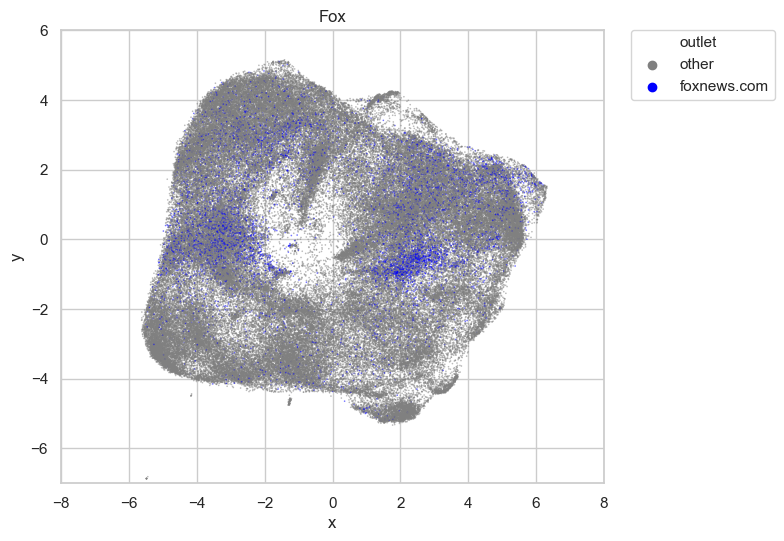

In [27]:
pdf = UMAP_POINTS.copy()
pdf['outlet'] = pdf.domain.apply(lambda d: d if d=='foxnews.com' else 'other')
palette = {'foxnews.com': 'blue', 'other': 'gray'}
plot_umap(pdf, palette, title='Fox')

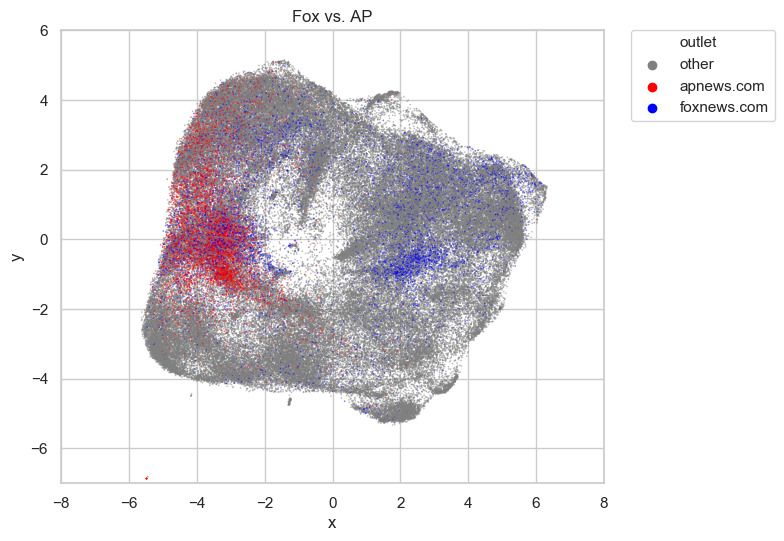

In [28]:
pdf = UMAP_POINTS.copy()
pdf['outlet'] = pdf.domain.apply(lambda d: d if d in ('apnews.com', 'foxnews.com') else 'other')
palette = {'apnews.com': 'red', 'foxnews.com': 'blue', 'other': 'gray'}
plot_umap(pdf, palette, title='Fox vs. AP')

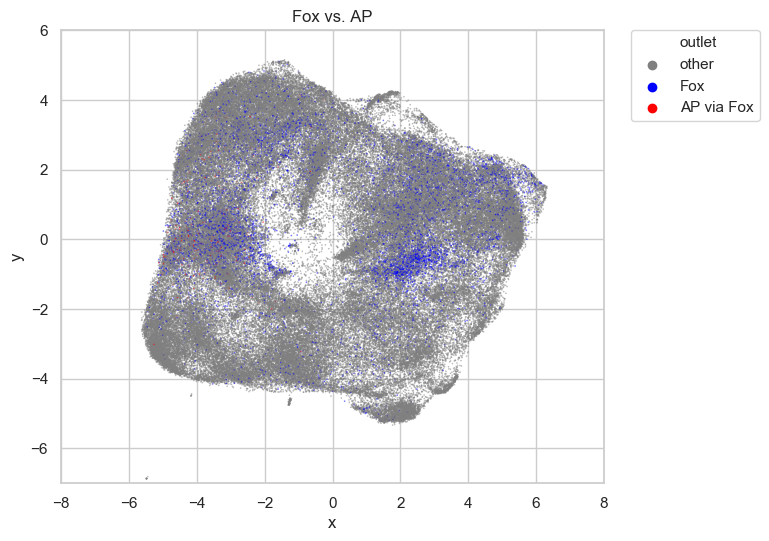

In [62]:
pdf = UMAP_POINTS.copy()
pdf['domains'] = pdf.domains.map(set)

def get_outlet(r):
    if r.domain == 'foxnews.com' and 'apnews.com' in r.domains:
        return 'AP via Fox'
    elif r.domain == 'foxnews.com':
        return 'Fox'
    else:
        return 'other'

pdf['outlet'] = pdf.apply(get_outlet, 1)

palette = {'AP via Fox': 'red', 'Fox': 'blue', 'other': 'gray'}
plot_umap(pdf, palette, title='Fox vs. AP')

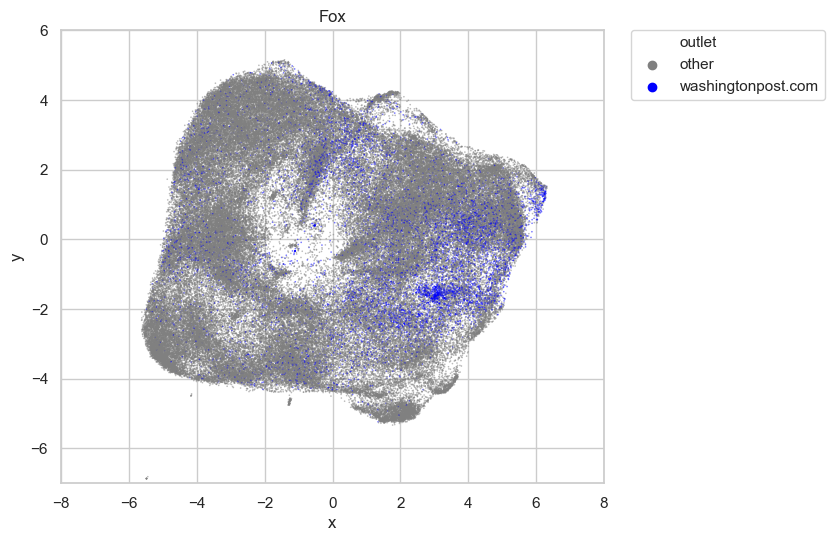

In [210]:
pdf = UMAP_POINTS.copy()
pdf['outlet'] = pdf.domain.apply(lambda d: d if d=='washingtonpost.com' else 'other')
palette = {'washingtonpost.com': 'blue', 'other': 'gray'}
plot_umap(pdf, palette, title='Fox')

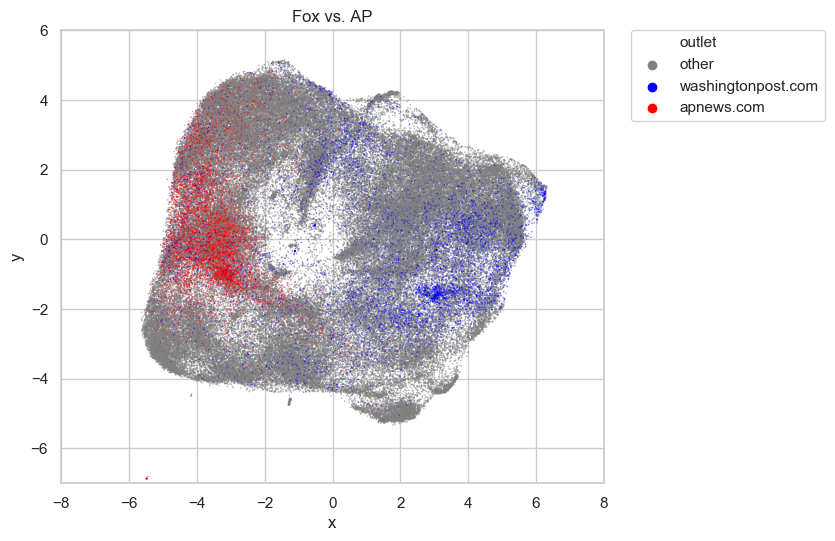

In [209]:
pdf = UMAP_POINTS.copy()
pdf['outlet'] = pdf.domain.apply(lambda d: d if d in ('apnews.com', 'washingtonpost.com') else 'other')
palette = {'apnews.com': 'red', 'washingtonpost.com': 'blue', 'other': 'gray'}
plot_umap(pdf, palette, title='Fox vs. AP')

# % of articles from AP

In [147]:
article_df = pd.DataFrame(read_json_gz_lines('../../data/clf-articles.json/'))

In [148]:
article_df['is_ap'] = article_df.domains.apply(lambda ds: 'apnews.com' in ds)

In [153]:
article_df[article_df.is_ap==True].groupby('domain').size() / article_df.groupby('domain').size()

domain
apnews.com            1.000000
bloomberg.com         0.008851
breitbart.com         0.009090
buzzfeed.com               NaN
cnn.com               0.000438
dailycaller.com       0.000126
dailykos.com          0.000083
foxnews.com           0.035745
huffingtonpost.com    0.000290
msnbc.com             0.000423
npr.org               0.000355
nytimes.com           0.010078
thehill.com           0.000461
washingtonpost.com    0.020717
wsj.com               0.001031
dtype: float64

# Nearby AP / Fox pairs

In [129]:
df, embeds = read_preds('../../data/ava-lstm-attn/')

100%|██████████| 284/284 [00:13<00:00, 30.39it/s]


In [130]:
df_train = df[df.split=='train']

In [204]:
def close_pairs(d1, d2, label1, label2, n_samples=1000000, n_pairs=20, plot=False):
    
    df1 = df_train[df_train.domain==d1]
    df2 = df_train[df_train.domain==d2]
    
    d1_embeds = embeds[df1.index]
    d2_embeds = embeds[df2.index]
    
    idx1 = np.random.choice(range(len(d1_embeds)), n_samples)
    idx2 = np.random.choice(range(len(d2_embeds)), n_samples)

    x1 = torch.from_numpy(d1_embeds[idx1])
    x2 = torch.from_numpy(d2_embeds[idx2])

    ds = F.cosine_similarity(x1, x2)
    ds = -(ds.numpy() - 1)
    
    if plot:
        sns.distplot(ds)
        plt.show()
    
    close_idxs = np.argsort(ds)[:n_pairs]
    
    for i1, i2 in zip(idx1[close_idxs], idx2[close_idxs]):
        line1 = ' '.join(df1.iloc[i1].clf_tokens)
        line2 = ' '.join(df2.iloc[i2].clf_tokens)
        print(f'{label1}: {line1}\n{label2}: {line2}\n')

In [205]:
close_pairs('apnews.com', 'foxnews.com', 'AP', 'Fox')

AP: trump targeting irs rule on churches
Fox: trump targeting irs rule on churches

AP: oregon boy # found in car trunk critically injured
Fox: indiana father charged with neglect in sons drownings

AP: egypt gunmen attack christians killing at least #
Fox: egypt church bombing kills at least #

AP: dad who dragged teen daughter through school avoids prison
Fox: man reunited with baby he saved with cpr on side of highway

AP: iran detains ex prosecutor convicted in # torture case
Fox: pakistani army says indian fire kills # soldiers in kashmir

AP: iran s revolutionary guard says hit syria for tehran attacks
Fox: egypt s islamic state affiliate claims deadly sinai attack

AP: honduras president says open to review of disputed vote
Fox: saudi arabia says corruption probe detainees will face trial

AP: parents baby girl attacked by raccoon inside apartment
Fox: mom investigating soldier son s death uncovers new evidence

AP: # officers killed in palestinian attack
Fox: # men believed mig

# Fox articles close to AP mean

In [135]:
idx = AnnoyIndex(embeds.shape[1])

for r in df_train[df_train.domain=='foxnews.com'].itertuples():
    idx.add_item(r.Index, embeds[r.Index])
    
idx.build(20)

True

In [138]:
ap_mean = embeds[df_train[df_train.domain=='apnews.com'].index].mean(0)

In [158]:
fox_ap_nns = df_train.loc[idx.get_nns_by_vector(ap_mean, 500)]

In [154]:
urls_df = pd.DataFrame(read_json_gz_lines('../../data/article-urls.json/'))

In [159]:
fox_ap_nns = fox_ap_nns.merge(urls_df)

In [165]:
session = HTMLSession()

In [186]:
def scrape_dc_source(url):
    
    r = session.get(url)
    sources = r.html.xpath('//meta[@name="dc.source"]/@content')
    source = sources[0] if sources else None
    
    print(url, source)
    return source

In [ ]:
fox_ap_nns['dc_source'] = fox_ap_nns.url.apply(scrape_dc_source)

In [190]:
fox_ap_nns.groupby('dc_source').size()

dc_source
Associated Press    320
Fox News            118
Fox News Insider      3
FoxNews.com          10
FoxSports             7
LifeZette.com         1
LiveScience           1
Motor Authority       1
Newser                1
Reuters               1
SkyNews               1
Travel + Leisure      1
Warrior Maven         1
news.com.au           1
dtype: int64

In [197]:
fox_ap_nns.groupby('dc_source').size().sum()

467

In [198]:
118/467

0.25267665952890794

In [199]:
320/467

0.6852248394004282

# Hill <-> (DC / BB)

In [207]:
close_pairs('thehill.com', 'dailycaller.com', 'The Hill', 'Daily Caller')

The Hill: dem candidate for va governor is fighting for ms #
Daily Caller: dem donor network wants reparations on agenda by #

The Hill: dems kick off unity commission
Daily Caller: house dems want comey tapes

The Hill: dem senator throws cold water on impeachment talk
Daily Caller: dem rep slams party leadership or lack thereof

The Hill: dems push leaders to talk less about russia
Daily Caller: dem reads trump tweets during sessions hearing

The Hill: dems up # points in party affiliation
Daily Caller: dem candidates racking in record breaking donations

The Hill: gop senator puts hold on trump energy nominee
Daily Caller: gop reps lash out at mnuchin after meeting

The Hill: scaramucci out as wh communications director
Daily Caller: acosta i brought heat to wh press briefing

The Hill: dem backed candidate wins wisconsin supreme court race
Daily Caller: moderate dems fear lack of support from national party

The Hill: dem calls for trump impeachment on house floor
Daily Caller: dem

In [208]:
close_pairs('thehill.com', 'breitbart.com', 'The Hill', 'Breitbart')

The Hill: nazareth mayor cancels christmas celebration over trump s jerusalem decision
Breitbart: public broadcaster admits to increasing booing sounds during trump davos speech

The Hill: bush era nato ambassador do we need any more evidence that trump is unfit for office
Breitbart: cher dems must win to stop gestapo tactics of ice and impeach trump

The Hill: house dems raised record $ # million in march
Breitbart: dem staffers boo trump at unity baseball game

The Hill: pot state dems want federal regulation of marijuana
Breitbart: dems say guerrilla tactics for gun control coming

The Hill: meghan mccain to cpac head why is nt there a modicum of respect for my family
Breitbart: kirsten gillibrand if dems win midterms first thing we should do is abolish ice

The Hill: dem mega donor steyer runs ads calling on hoyer to support impeaching trump
Breitbart: dem rep introduces bill to block trump from using federal funds to pay for border wall

The Hill: graham rips trump over anti musli

In [211]:
close_pairs('thehill.com', 'msnbc.com', 'The Hill', 'MSNBC')

The Hill: trump has abdicated his responsibility as president
MSNBC: trump has the worst lawyers of any president

The Hill: dems wonder can gop even pass a budget
MSNBC: dems need more than anti trump message

The Hill: senate dem sees looming constitutional crisis
MSNBC: female dems plan more political engagement

The Hill: dems will cave if republicans go
MSNBC: dem leadership is old and creaky

The Hill: dems fundraising off of trump comments attacking lewis
MSNBC: dem senator vows to expose medicaid cuts in gop plan

The Hill: trump doubles down on merck attack
MSNBC: trump backs down repeatedly

The Hill: cohen tape is powerful exculpatory evidence
MSNBC: cohen wiretapping was unjustified

The Hill: dems will oppose short term spending bill
MSNBC: dems plan filibuster to block gorsuch

The Hill: senate dem to intel chief answer my surveillance question publicly
MSNBC: dem candidate for ny ag open to prosecute trump aides if pardoned

The Hill: intel committee dems to trump read t